In [1]:
import os

import matplotlib.pyplot as plt
import torch
import torchaudio
import torchvision
import torchvision.transforms as transforms

from model import *
from PIL import Image
import numpy as np
import cv2

d:\TSINGHUA\NLP\video-captioning-v2\venv\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')


In [2]:
AUDIO_FILE = 'video1.wav'
audio, sr = torchaudio.load(AUDIO_FILE)
print(audio.shape)
print(sr)


torch.Size([2, 970200])
44100


In [3]:
encoder_a = AudioEncoder(embedding_dim=128).cuda()
# features = encoder_a(audio.permute(1,0).numpy(), sr=sr)
features = encoder_a.from_tensor(audio, sr)
# features = encoder_a(AUDIO_FILE)
print(features.shape)

Using cache found in C:\Users\hector/.cache\torch\hub\harritaylor_torchvggish_master
torch.Size([22, 128])


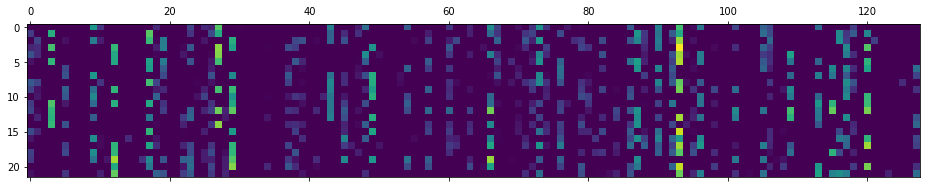

In [4]:
plt.matshow(features.detach().cpu().numpy())
plt.show()

In [2]:
IMAGE_FILE = os.path.join('flickr8k', 'images', '10815824_2997e03d76.jpg')

img_transforms = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((299, 299)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

img = Image.open(IMAGE_FILE).convert("RGB")
img = img_transforms(img)

In [68]:
encoder_v = VisualEncoder(embedding_dim=128).cuda()
encoder_v.transforms = None
img_features = encoder_v(img.unsqueeze(0).cuda())
# img_features = encoder_v(img)
print(img_features.shape)

torch.Size([1, 128])


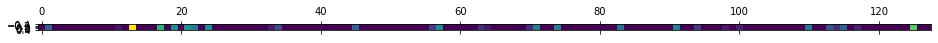

In [14]:
plt.matshow(img_features.detach().cpu().numpy())
plt.show()

In [81]:
def load_frames(video_filename, take_n=0, take_max=None):
    frames = []
    cap = cv2.VideoCapture(VIDEO_FILENAME)
    while cap.isOpened():
        ret, frame = cap.read()

        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        else:
            break

    frames = np.array(frames)

    if take_max and frames.shape[0] > take_max:
        take_n = take_max

    if take_n > 0:
        total_frames = frames.shape[0]
        frame_idx = np.arange(0, total_frames, total_frames//take_n+1)
        print(frame_idx)
        frames = frames[frame_idx,:,:,:]

    return frames

In [92]:
encoder_v = VisualEncoder(embedding_dim=128).cuda()
encoder_v.transforms = None

In [93]:
VIDEO_FILENAME = os.path.join('datasets', 'MSVD', 'videos', '_0nX-El-ySo_83_93.avi')
frames = load_frames(VIDEO_FILENAME, take_max=50)
print(frames.shape)

[  0   7  14  21  28  35  42  49  56  63  70  77  84  91  98 105 112 119
 126 133 140 147 154 161 168 175 182 189 196 203 210 217 224 231 238 245
 252 259 266 273 280 287 294]
(43, 720, 1280, 3)


In [94]:
# vframes, aframes, info = torchvision.io.read_video(VIDEO_FILENAME)


In [95]:
video_transforms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        lambda x: x.unsqueeze(0)
    ]
)

frames_tr = list(map(video_transforms, [frames[i,] for i in range(frames.shape[0])]))
frames_tr = torch.cat(frames_tr, dim=0)

print(frames_tr.shape)

# video_features = list(map(lambda x: encoder_v(img_transforms(x).unsqueeze(0).cuda()).detach().cpu(), [Image.fromarray(frames[i,]) for i in range(frames.shape[0])] )) 
# video_features = torch.cat(video_features, dim=0)

# video_features = encoder_v(frames_tr)

torch.Size([43, 3, 299, 299])


In [96]:
video_features = encoder_v(frames_tr.cuda())
print(video_features.shape)

torch.Size([43, 128])
